### Challenge

In this notebook we will apply dimensionality reduction techniques to visualize the observations and use clustering techniques to group together similar observations.

In each of the tasks above, we will try alternative methods and select the best performing one. Finally, we discuss how dimensionality reduction and clustering algorithms enable us to gain insights regarding the data.

### Objective

The objective of this analysis is to group wines with similar characteristics into clusters.  This can be used by connaisseurs to find new wines with a similar flavor to those they already enjoy.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn import linear_model
import time
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, MiniBatchKMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_df = pd.read_csv('Dataset zips/wine-customer-segmentation/wine.csv')

In [3]:
df = raw_df.copy()

### Data Exploration and Cleaning

We will start by looking at the characteristics of the dataframe.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alcohol               178 non-null    float64
 1   Malic_Acid            178 non-null    float64
 2   Ash                   178 non-null    float64
 3   Ash_Alcanity          178 non-null    float64
 4   Magnesium             178 non-null    int64  
 5   Total_Phenols         178 non-null    float64
 6   Flavanoids            178 non-null    float64
 7   Nonflavanoid_Phenols  178 non-null    float64
 8   Proanthocyanins       178 non-null    float64
 9   Color_Intensity       178 non-null    float64
 10  Hue                   178 non-null    float64
 11  OD280                 178 non-null    float64
 12  Proline               178 non-null    int64  
 13  Customer_Segment      178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


All features contain no null values and all datatypes are numeric.

Next let's look at the descriptive statistics for each feature.

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Alcohol,178.0,13.000618,0.811827,11.03,12.3625,13.050,13.6775,14.83
Malic_Acid,178.0,2.336348,1.117146,0.74,1.6025,1.865,3.0825,5.80
Ash,178.0,2.366517,0.274344,1.36,2.2100,2.360,2.5575,3.23
Ash_Alcanity,178.0,19.494944,3.339564,10.60,17.2000,19.500,21.5000,30.00
Magnesium,178.0,99.741573,14.282484,70.00,88.0000,98.000,107.0000,162.00
Total_Phenols,178.0,2.295112,0.625851,0.98,1.7425,2.355,2.8000,3.88
Flavanoids,178.0,2.029270,0.998859,0.34,1.2050,2.135,2.8750,5.08
Nonflavanoid_Phenols,178.0,0.361854,0.124453,0.13,0.2700,0.340,0.4375,0.66
Proanthocyanins,178.0,1.590899,0.572359,0.41,1.2500,1.555,1.9500,3.58
Color_Intensity,178.0,5.058090,2.318286,1.28,3.2200,4.690,6.2000,13.00


No features have a standard deviation significantly larger than the mean.  There are no egregious outliers at the min or max value.  We will be ignoring the Customer_Segment fields and designing our own segments. 

Thus we will have 13 features to work with.  

In [6]:
df = df.drop('Customer_Segment', axis = 1)

Next we will examine the histograms of each feature.

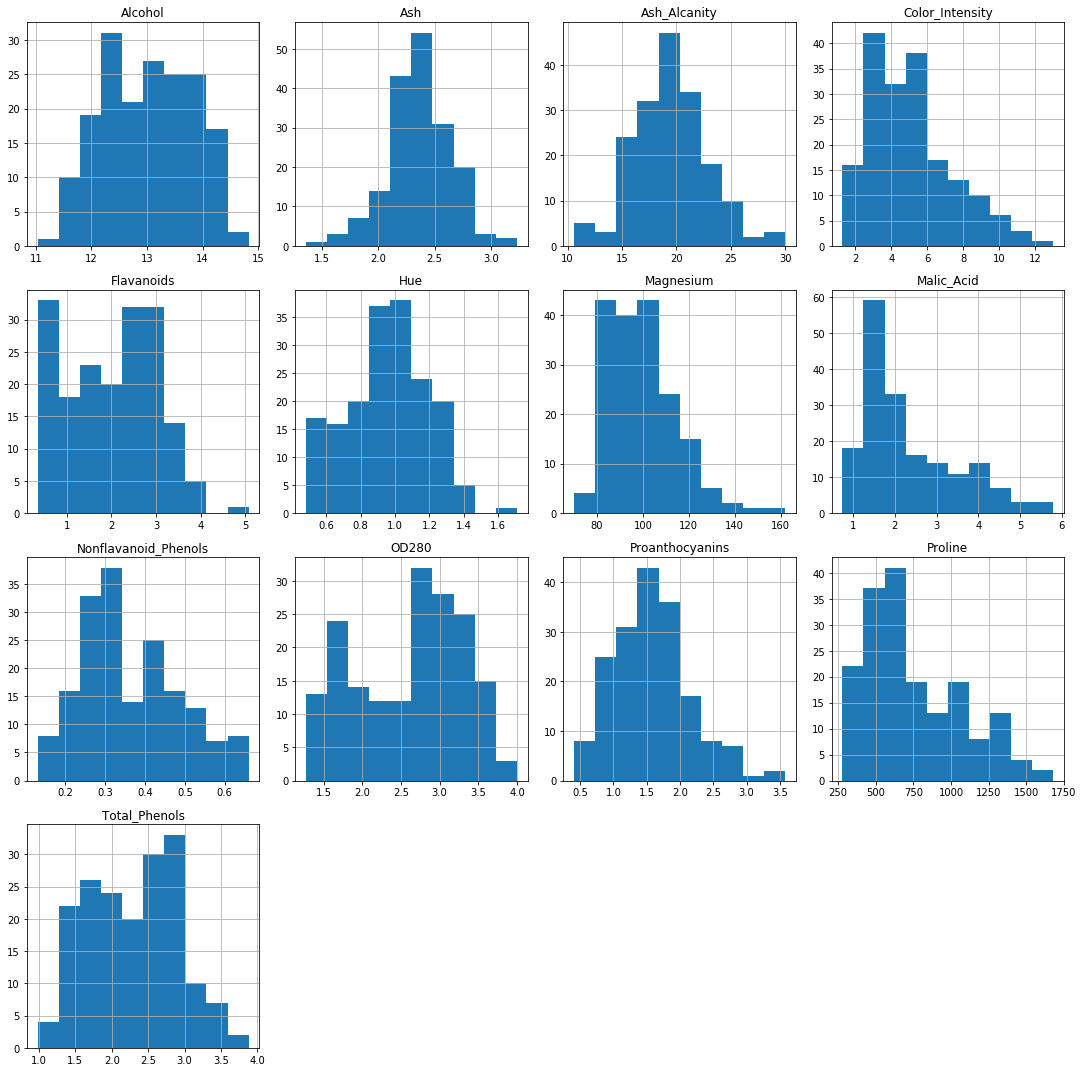

In [7]:
df.hist(figsize=(15,15))
plt.tight_layout()

We should examine the correlations between the features.

In [8]:
df.corr()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
Alcohol,1.000000,0.094397,0.211545,-0.310235,0.270798,0.289101,0.236815,-0.155929,0.136698,0.546364,-0.071747,0.072343,0.643720
Malic_Acid,0.094397,1.000000,0.164045,0.288500,-0.054575,-0.335167,-0.411007,0.292977,-0.220746,0.248985,-0.561296,-0.368710,-0.192011
Ash,0.211545,0.164045,1.000000,0.443367,0.286587,0.128980,0.115077,0.186230,0.009652,0.258887,-0.074667,0.003911,0.223626
Ash_Alcanity,-0.310235,0.288500,0.443367,1.000000,-0.083333,-0.321113,-0.351370,0.361922,-0.197327,0.018732,-0.273955,-0.276769,-0.440597
Magnesium,0.270798,-0.054575,0.286587,-0.083333,1.000000,0.214401,0.195784,-0.256294,0.236441,0.199950,0.055398,0.066004,0.393351
Total_Phenols,0.289101,-0.335167,0.128980,-0.321113,0.214401,1.000000,0.864564,-0.449935,0.612413,-0.055136,0.433681,0.699949,0.498115
Flavanoids,0.236815,-0.411007,0.115077,-0.351370,0.195784,0.864564,1.000000,-0.537900,0.652692,-0.172379,0.543479,0.787194,0.494193
Nonflavanoid_Phenols,-0.155929,0.292977,0.186230,0.361922,-0.256294,-0.449935,-0.537900,1.000000,-0.365845,0.139057,-0.262640,-0.503270,-0.311385
Proanthocyanins,0.136698,-0.220746,0.009652,-0.197327,0.236441,0.612413,0.652692,-0.365845,1.000000,-0.025250,0.295544,0.519067,0.330417
Color_Intensity,0.546364,0.248985,0.258887,0.018732,0.199950,-0.055136,-0.172379,0.139057,-0.025250,1.000000,-0.521813,-0.428815,0.316100


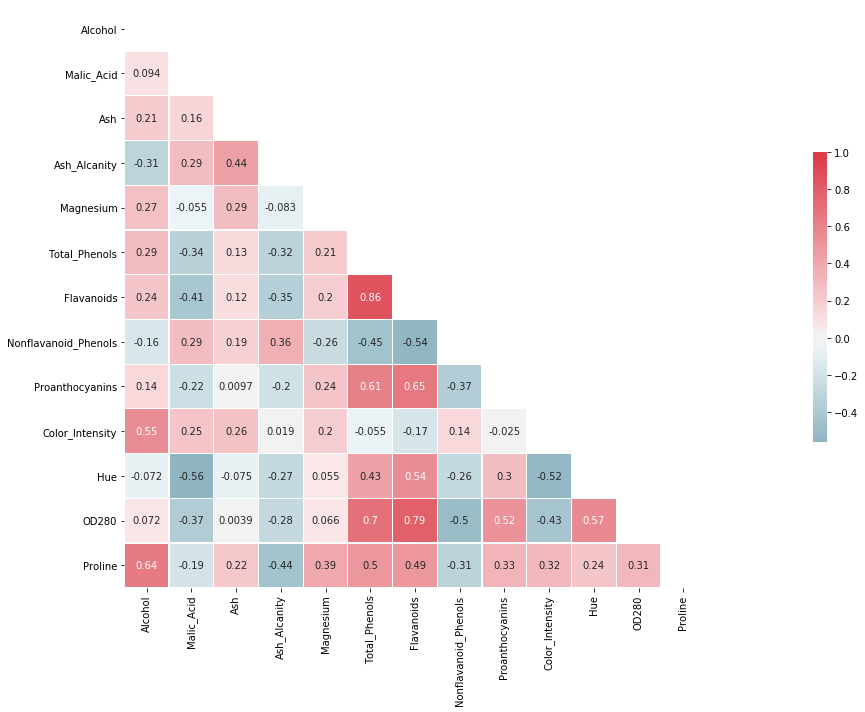

In [9]:
# Generate a mask for the upper triangle
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.figure(figsize=(30,10))
sns.heatmap(df.corr(), mask=mask, cmap= cmap, center=0, square=True, linewidths=.2, cbar_kws={"shrink": .5}, annot = True)

plt.tight_layout()
#adapted code from kirgsn

Some features are higly correlated: > 0.7

Nonflavanoid_Phenols and Total_Phenols

OD280 and Total Phenols

OD280 and Flavanoids

The pairplot below shows these correlations in more depth.

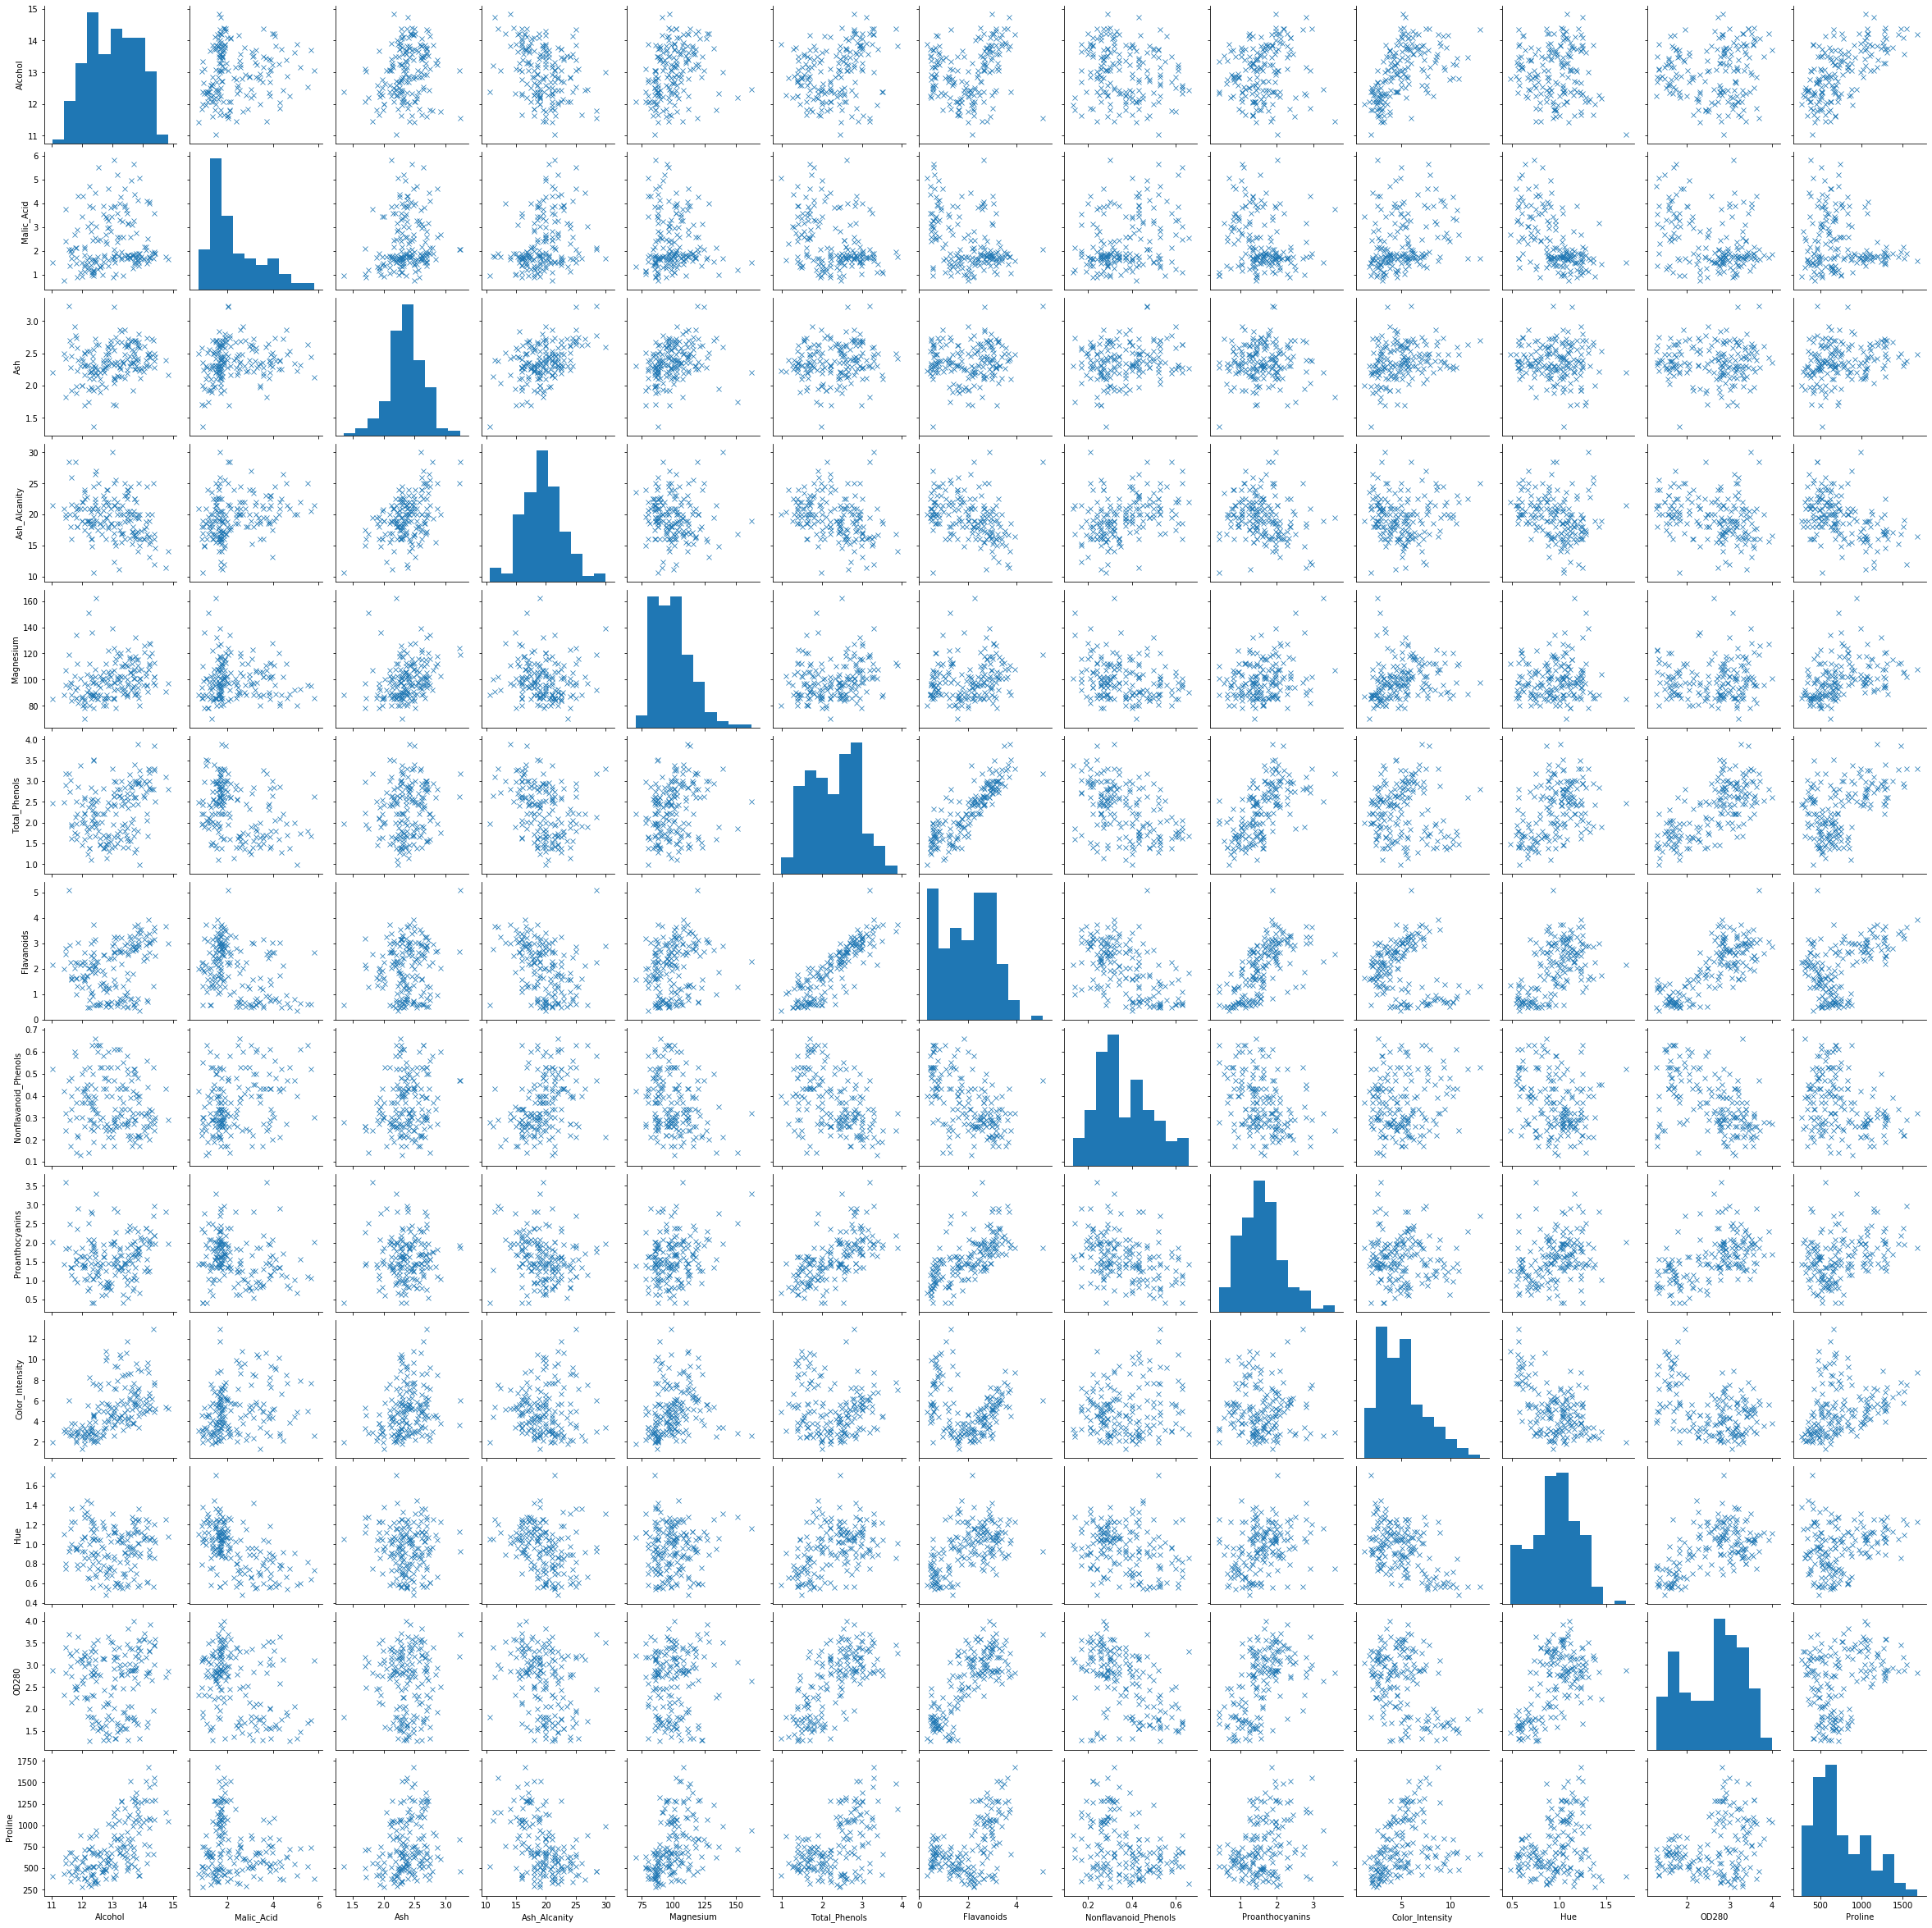

In [10]:
sns.pairplot(df, markers= 'x', palette="husl")

### Modeling

Before ingesting the data into the model, we will standaradize and normalize all features. 

In [11]:
# Standarizing the features
scaler = StandardScaler()

standardized_df = scaler.fit_transform(df)
df_std = pd.DataFrame(standardized_df)

# Normalizing the features
normalized_df = normalize(df_std)
df_norm = pd.DataFrame(normalized_df) 

#### Metrics

To score the models, we will use the Silhouette score as a metric.  I will add each model to a dataframe with its score to rank them at the end.

In [12]:
df_scores = pd.DataFrame(columns = ['algorithm', 'silhouette_score'])

We will also have all models use the same random state to avoid changes between runs.

In [13]:
state = 123456

### Visualization

First we will explore three dimensionality reduction techniques.  Each will be limited to 2 dimensions for visualization.

Principle Component Analysis (PCA): This dimension reduction technique only needs the number of components specified as a hyperparameter.  

t_Distributed Stochastic Neighbor Embedding (t_SNE): For t_SNE I have tuned the perplexity and n_iter to find distince clusters. 

Uniform Manifold Approximation and Projection (UMAP): I have tuned the n_neighbors and min_dist hyperparemeters for UMAP, the default values worked best.  

#### PCA

We will make a dataframe of 2 components from PCA for visualization.

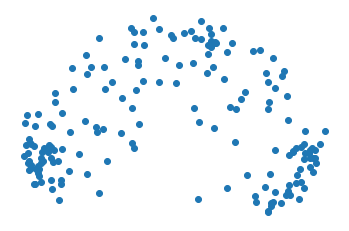

In [14]:
# Dimension reduction to 2 features
pca = PCA(n_components=2).fit_transform(df_norm)

df_pca = pd.DataFrame(pca, columns = ['component_1', 'component_2'])

plt.scatter(df_pca['component_1'], df_pca['component_2'])

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

The PCA algorithm does not create distinct clusters for visualization on two dimentions.  It is possible to pick out 3 dense areas of datapoints, but they blend at the boundaries.  

#### t-SNE

In [15]:
time_start = time.time()
tsne = TSNE(n_components=2, perplexity=40, n_iter=300, random_state = state)
tsne_results = tsne.fit_transform(df_norm)
df_tsne = pd.DataFrame(tsne_results, columns = [0, 1])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 0.4204225540161133 seconds


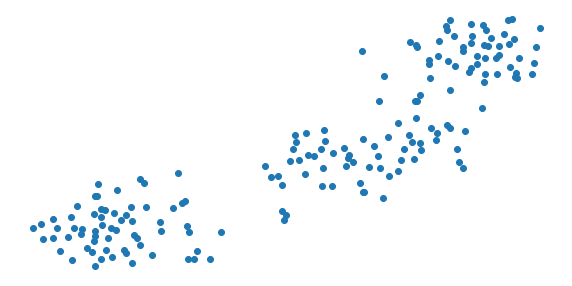

In [16]:
plt.figure(figsize=(10,5))
plt.scatter(df_tsne[0], df_tsne[1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

There is one distinct cluster in the bottom left, but the rest of the datapoints are not grouped well and could be one or multiple clusters. 

#### UMAP

In [17]:
time_start = time.time()

umap_results = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state = state).fit_transform(df_norm)
df_umap = pd.DataFrame(umap_results, columns = [0, 1])

print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))

UMAP done! Time elapsed: 4.8762123584747314 seconds


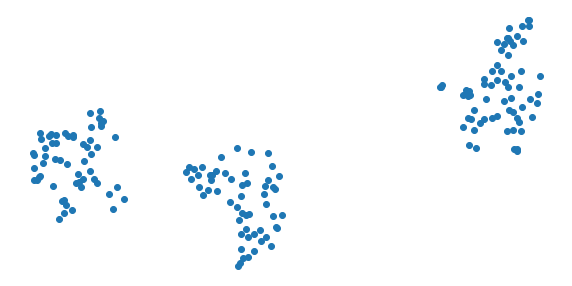

In [18]:
plt.figure(figsize=(10,5))
plt.scatter(df_umap[0], df_umap[1])    
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

The UMAP algorithm creates 3 distinct clusters.  Perhaps these will be reflected in the clustering models.

### Clustering

Now we will test various clustering models and then visualize by reducing to 2 dimensions. 

#### K-means

To start, we will examine the K-Means clustering algorithm.  This will create clusters with comparable size.  Thus, each group should have a similar number of datapoints.  

Lets examine the elbow plot to determine how many clusters are optimal.

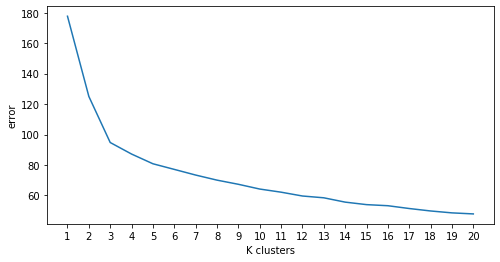

In [19]:
errors = {}
for k in range(1, 21):
    kmeans_cluster = KMeans(n_clusters = k, random_state = state).fit(df_norm)
    errors[k] = kmeans_cluster.inertia_  # Sum of distances of samples to their closest cluster center 
plt.figure(figsize = (8, 4))
plt.plot(list(errors.keys()), list(errors.values()))
plt.xticks(range(1, 21))
plt.xlabel("K clusters")
plt.ylabel("error")
plt.show()

The bend of this elbow plot occurs at 3 cluster.  It flattens out by 6 clusters.  We will limit our K-Means analysis to under 6 clusters.  

In [20]:
silhouette_scores = []
clusters = range(2, 6)

for k in clusters:
    silhouette_scores.append(silhouette_score(df_norm, KMeans(n_clusters = k, random_state = state).fit_predict(df_norm)))

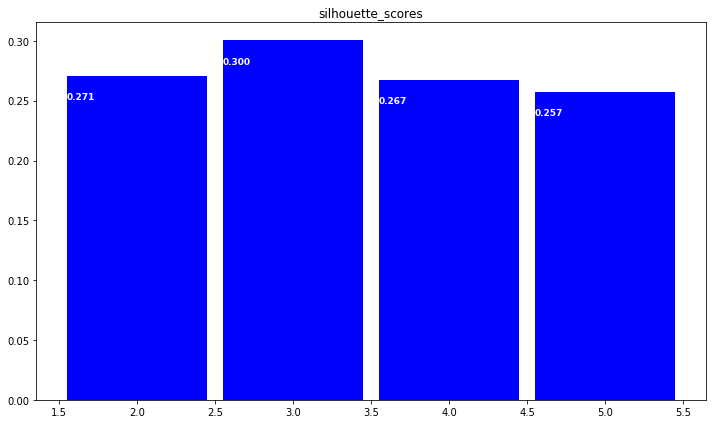

In [21]:
plt.figure(figsize = (10, 6))
plt.bar(clusters, silhouette_scores, color = 'b', width = 0.9)
plt.title('silhouette_scores')
for index,data in enumerate(silhouette_scores):
    plt.text(x = index + 1.55, y = data - .02, color = 'w', s = f"{data}"[:5], fontdict=dict(fontsize=9, weight = 'bold'))
plt.tight_layout()

The highest silhouette score occurs at 3 clusters as expected. 

Lets examine how these clusters appear when projected onto two dimensions with PCA.

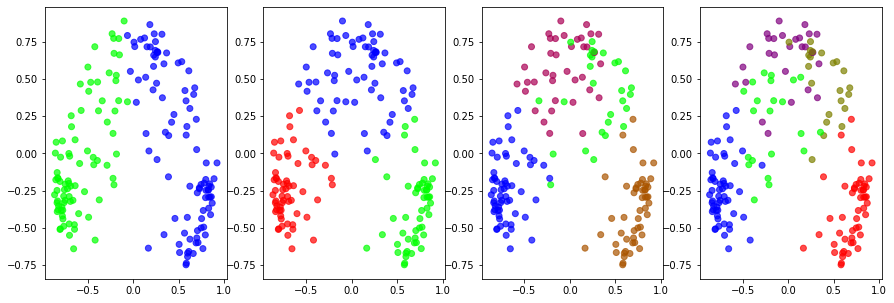

In [22]:
plt.figure(figsize = (15, 5))
subplots = [141, 142, 143, 144]
count = 0
for k in range(2, 6):
    plt.subplot(subplots[count])
    plt.scatter(df_pca['component_1'], df_pca['component_2'], c = KMeans(n_clusters = k, random_state = state).fit_predict(df_norm), cmap = 'brg', alpha = 0.7)
    count += 1
plt.show()

The 3 cluster solution has distinct clusters.  At 4 the clusters begin to have significant overlap when projected onto 2 dimensions.  

How about projecting with t_SNE?

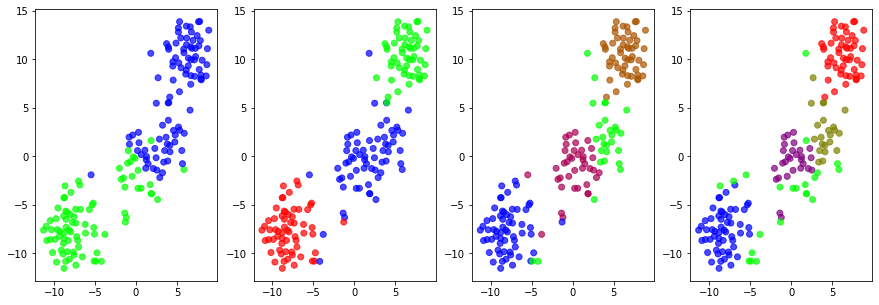

In [23]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=300, random_state = state)
tsne_results = tsne.fit_transform(df_norm)
df_tsne = pd.DataFrame(tsne_results, columns = [0, 1])

plt.figure(figsize = (15, 5))
subplots = [141, 142, 143, 144]
count = 0
for k in range(2, 6):
    plt.subplot(subplots[count])
    plt.scatter(df_tsne[0], df_tsne[1], c = KMeans(n_clusters = k, random_state = state).fit_predict(df_norm), cmap = 'brg', alpha = 0.7)
    count += 1
plt.show()

For the 3 cluster solution, the middle cluster overlaps in the visualization. 

Does projecting on UMAP result in distinct clusters?

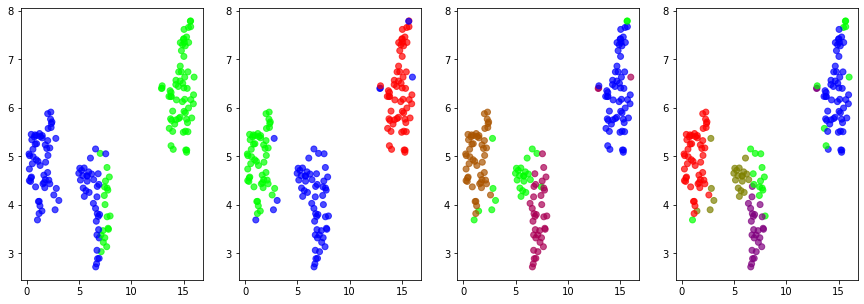

In [24]:
umap_results = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state = state).fit_transform(df_norm)
df_umap = pd.DataFrame(umap_results, columns = [0, 1])

plt.figure(figsize = (15, 5))
subplots = [141, 142, 143, 144]
count = 0
for k in range(2, 6):
    plt.subplot(subplots[count])
    plt.scatter(df_umap[0], df_umap[1], c = KMeans(n_clusters = k, random_state = state).fit_predict(df_norm), cmap = 'brg', alpha = 0.7)
    count += 1
plt.show()

There are a few datapoints that do not appear to be assigned to the correct cluster based on the visualization.  This is likely due to information lost when projecting onto 2 dimensions.  

Overall it appears the 3 cluster solution performs the best and has mostly distinct clusters in all 3 visualizations. We will add it to the dataframe of scores.

In [25]:
df_clusters_3_means = pd.DataFrame(KMeans(n_clusters = 3, random_state = state).fit(df_norm).predict(df_norm))
df['3_MEANS'] = df_clusters_3_means
df_scores = df_scores.append({'algorithm' : '3_means' , 'silhouette_score' : silhouette_score(df_norm, KMeans(n_clusters = 3, random_state = state).fit_predict(df_norm))}, ignore_index = True)

#### Gaussian Mixture Model

Unlike a K-Means algorithm, the Gaussian Mixture Model can identify clusters of varied size.  This may be useful if there is a specific group of wines with very similar characteristics.  

We cannot construct an elbow plot because there is no inherent analogue to the inertia_ attribute from K-Means.  

In [26]:
silhouette_scores = []
clusters = range(2, 6)

for k in clusters:
    silhouette_scores.append(silhouette_score(df_norm, GaussianMixture(n_components = k, random_state = state).fit_predict(df_norm)))

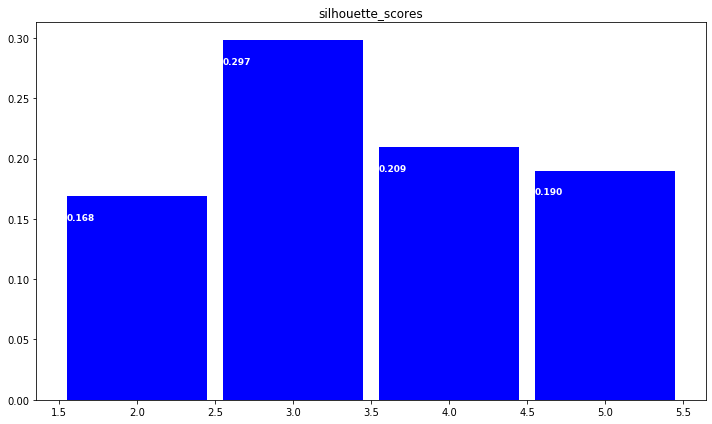

In [27]:
plt.figure(figsize = (10, 6))
plt.bar(clusters, silhouette_scores, color = 'b', width = 0.9)
plt.title('silhouette_scores')
for index,data in enumerate(silhouette_scores):
    plt.text(x = index + 1.55, y = data - .02, color = 'w', s = f"{data}"[:5], fontdict=dict(fontsize=9, weight = 'bold'))
plt.tight_layout()

Again the 3 cluster solution has the highest silhouette score by far.   The silhouette score is close to the 3-Mean solution aswell.

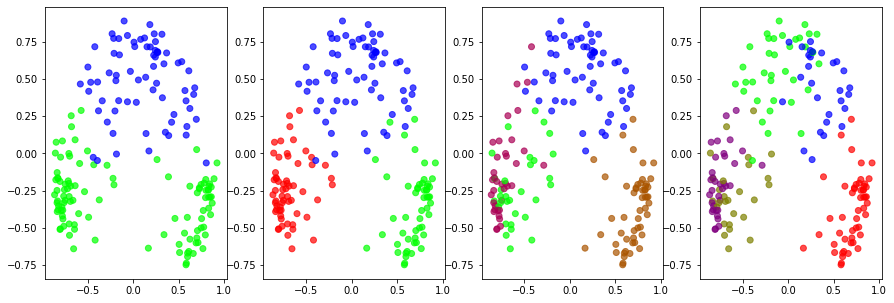

In [28]:
plt.figure(figsize = (15, 5))
subplots = [141, 142, 143, 144]
count = 0
for k in range(2, 6):
    plt.subplot(subplots[count])
    plt.scatter(df_pca['component_1'], df_pca['component_2'], c = GaussianMixture(n_components = k, random_state = state).fit_predict(df_norm), cmap = 'brg', alpha = 0.7)
    count += 1
plt.show()

Both the guassian mixture model and K means model have similar scores for 3 clusters.  From the visualizations you can see that there is slight overlap in the guassian mixture when projected to 2 dimensions using PCA.  

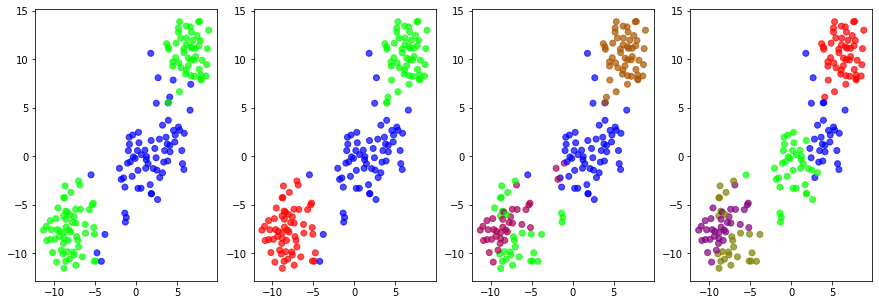

In [29]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=300, random_state = state)
tsne_results = tsne.fit_transform(df_norm)
df_tsne = pd.DataFrame(tsne_results, columns = [0, 1])

plt.figure(figsize = (15, 5))
subplots = [141, 142, 143, 144]
count = 0
for k in range(2, 6):
    plt.subplot(subplots[count])
    plt.scatter(df_tsne[0], df_tsne[1], c = GaussianMixture(n_components = k, random_state = state).fit_predict(df_norm), cmap = 'brg', alpha = 0.7)
    count += 1
plt.show()

For the 3 cluster solution, the middle cluster overlaps in the visualization from t_SNE. 

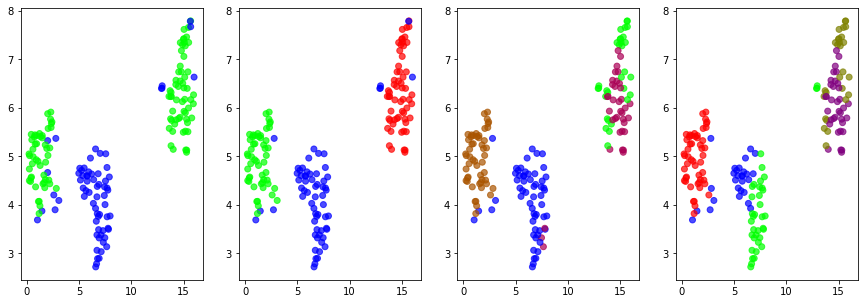

In [30]:
umap_results = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state = state).fit_transform(df_norm)
df_umap = pd.DataFrame(umap_results, columns = [0, 1])

plt.figure(figsize = (15, 5))
subplots = [141, 142, 143, 144]
count = 0
for k in range(2, 6):
    plt.subplot(subplots[count])
    plt.scatter(df_umap[0], df_umap[1], c = GaussianMixture(n_components = k, random_state = state).fit_predict(df_norm), cmap = 'brg', alpha = 0.7)
    count += 1
plt.show()

There are a few datapoints that do not appear to be assigned to the correct cluster based on the visualization from UMAP.  This is likely due to information lost when projecting onto 2 dimensions.  

Overall it appears the 3 cluster solution again performs the best and has mostly distinct clusters in all 3 visualizations.  

In [31]:
df_clusters_3_gmm = pd.DataFrame(GaussianMixture(n_components = 3, random_state = state).fit(df_norm).predict(df_norm))
df['3_GMM'] = df_clusters_3_gmm
df_scores = df_scores.append({'algorithm' : '3_gmm' , 'silhouette_score' : silhouette_score(df_norm, GaussianMixture(n_components = 3, random_state = state).fit_predict(df_norm))}, ignore_index = True)

#### Hierarchical Agglomerative Clustering

In the Hierarchical Agglomerative clustering algorithm, each datapoint will start its own cluster, then similar pairs will be merged until we reach the optimal number of clusters.  This method is slow, O(n^3), but our dataset is not too large for this to be prohibitive. 

The advantage of Heirarchical Agglomerative clustering is that very similar datapoints will always be in the same cluster, instead of straddling the boundary.  However, it can create clusters of vastly different size, and may not assign clusters based on the overall similarity of their members.  

We will explore all of the various linkage and affinity types.

In [32]:
df_agg_scores = pd.DataFrame(columns = ['linkage', 'affinity', 'clusters', 'silhouette_score'])

In [33]:
def score_agg_cluster(data, n_clusters, linkage_type, affinity_type):
    global df_agg_scores
    agg_cluster = AgglomerativeClustering(linkage=linkage_type, 
                                          affinity=affinity_type,
                                          n_clusters=n_clusters)
    clusters = agg_cluster.fit_predict(data)
    df_agg_scores = df_agg_scores.append({'linkage' : linkage_type, 'affinity' : affinity_type, 'clusters' : n_clusters, 'silhouette_score' : silhouette_score(df_norm, clusters, metric=affinity_type)}, ignore_index = True)

In [34]:
# Long runtime
data = df_norm
for linkages in ['complete', 'average']:
    linkage_type = linkages
    for affinities in ['cosine', 'euclidean', 'manhattan']:
        affinity_type = affinities
        for clusters in range(2, 6):
            score_agg_cluster(data, clusters, linkage_type, affinity_type)
            
linkage_type='ward'
affinity_type='euclidean'
for clusters in range(2, 6):
    score_agg_cluster(data, clusters, linkage_type, affinity_type)


In [35]:
df_agg_scores.sort_values(by = ['silhouette_score'], ascending = [False]).head(10)

,linkage,affinity,clusters,silhouette_score
13,average,cosine,3,0.443214
1,complete,cosine,3,0.415435
14,average,cosine,4,0.414508
15,average,cosine,5,0.407714
0,complete,cosine,2,0.392419
12,average,cosine,2,0.383012
2,complete,cosine,4,0.372989
9,complete,manhattan,3,0.319895
21,average,manhattan,3,0.316326
3,complete,cosine,5,0.302528


Creating 3 clusters with the average linkage and cosine affinity results in the highest silhouette score of 0.443.  This is significantly higher than our earlier clustering algorithms.

We can inspect the dendrogram for these hyperparemeters.

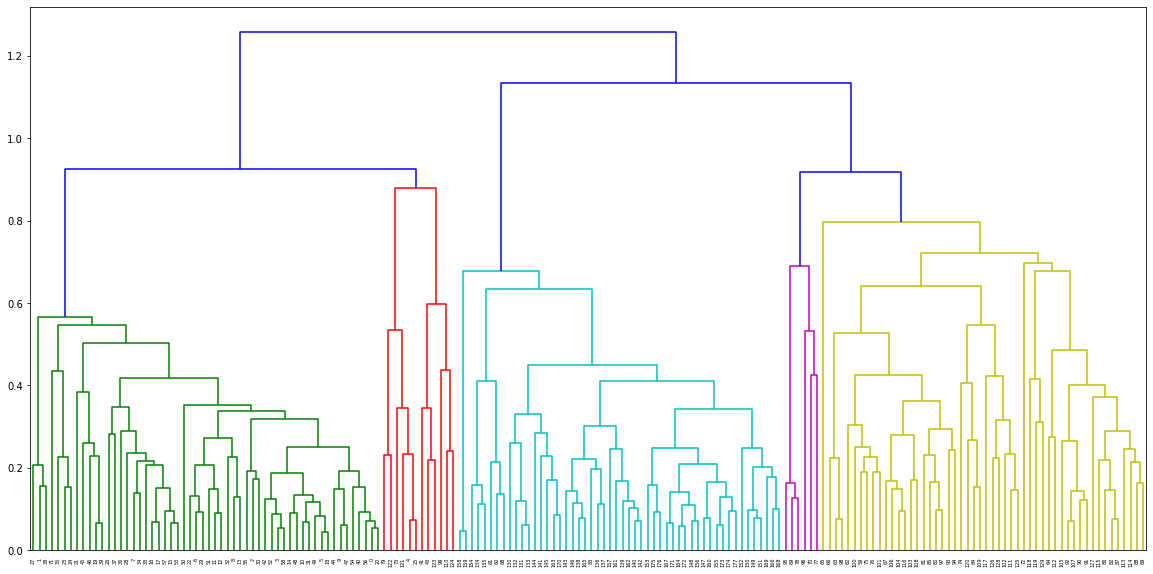

In [36]:
plt.figure(figsize=(20,10))
dendrogram(linkage(df_norm, method = 'average', metric = 'cosine'))
plt.show()

Focusing on the part of the dendrogram with 3 clusters (a horizontal line cuts 3 vertical lines) it appears that all 3 clusters are relatively close in size so this algorithm performs well. 

In [37]:
linkage_type='average'
affinity_type='cosine'

agg_cluster = AgglomerativeClustering(linkage=linkage_type, 
                                      affinity=affinity_type,
                                      n_clusters=3)
clusters = agg_cluster.fit_predict(df_norm)
df['3_AVG_COS_AGG'] = clusters
df_scores = df_scores.append({'algorithm' : '3_avg_cos_agg' , 'silhouette_score' : silhouette_score(df_norm, clusters, metric=affinity_type)}, ignore_index = True)

How do the clusters look when projected on 2 dimensions?

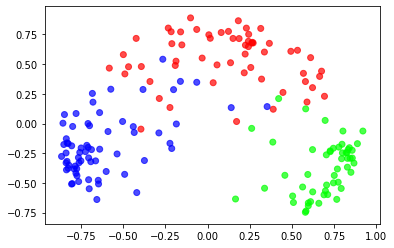

In [38]:
plt.scatter(df_pca['component_1'], df_pca['component_2'], c = clusters, cmap = 'brg', alpha = 0.7)
plt.show()

There is some overlap between clusters when visualized, but it is easy to identify each of the 3 clusters.

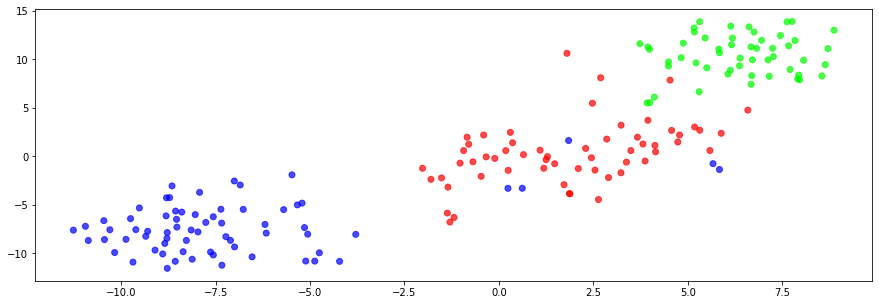

In [39]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=300, random_state = state)
tsne_results = tsne.fit_transform(df_norm)
df_tsne = pd.DataFrame(tsne_results, columns = [0, 1])

plt.figure(figsize = (15, 5))
plt.scatter(df_tsne[0], df_tsne[1], c = clusters, cmap = 'brg', alpha = 0.7)
plt.show()

For the 3 cluster solution, the middle cluster overlaps in the visualization.  

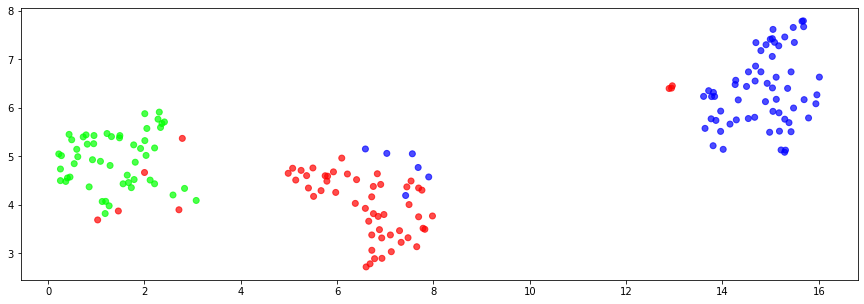

In [40]:
umap_results = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state = state).fit_transform(df_norm)
df_umap = pd.DataFrame(umap_results, columns = [0, 1])

plt.figure(figsize = (15, 5))
plt.scatter(df_umap[0], df_umap[1], c = clusters, cmap = 'brg', alpha = 0.7)
plt.show()

There are a few datapoints that do not appear to be assigned to the correct cluster based on the visualization.  This is likely due to information lost when projecting onto 2 dimensions.  

Overall it appears the 3 cluster solution performs the best and has mostly distinct clusters in all 3 visualizations.  

We can trust the high silhouette score indicates that each cluster is distinct.  

#### DBSCAN

The Density Based Spatial Clustering of Applications with Noise will identify clusters by starting with a core point, then creating a cluster enough others are within the epsilon.  Those without enough nearby points are assigned as noise.  

Its strength is finding oddly shaped clusters such as rings, and excluding outlying datapoints.

In [41]:
# Long runtime
silhouette_scores = []
best_silhouette = pd.DataFrame(data = {'epsilon': [0], 'min_samples': [0], 'clusters': [0], 'silhouette_score': [0]})
for eps in np.arange(0.02, 3, 0.02):
    for samples in range(2, 60, 2):
        dbscan_series = pd.Series(DBSCAN(eps = eps, min_samples = samples).fit_predict(df_norm))
        if dbscan_series.unique().shape[0] > 1:
            current_clusters = DBSCAN(eps = eps, min_samples = samples).fit_predict(df_norm)
            silhouette = silhouette_score(df_pca, current_clusters)
            silhouette_scores.append(silhouette)
            if silhouette > best_silhouette['silhouette_score'][0]:
                best_silhouette.loc[0] = [eps, samples, dbscan_series.unique().shape[0], silhouette]
                best_clusters = current_clusters

I have implimented a grid search to find the best hyperparemeters based on silhouette score.

In [42]:
best_silhouette

,epsilon,min_samples,clusters,silhouette_score
0,0.94,40,3,0.579108


The DBSCAN algorithm has the highest silhouette score by far and thus found the most distinct clusters.  

How do they appear in the visualizations?

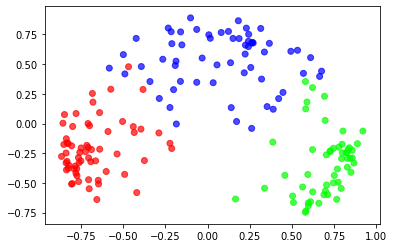

In [43]:
plt.scatter(df_pca['component_1'], df_pca['component_2'], c = best_clusters, cmap = 'brg', alpha = 0.7)
plt.show()

There are 3 identifiable clusters.  Only slight overlap appears at the boundaries of the PCA visualization.

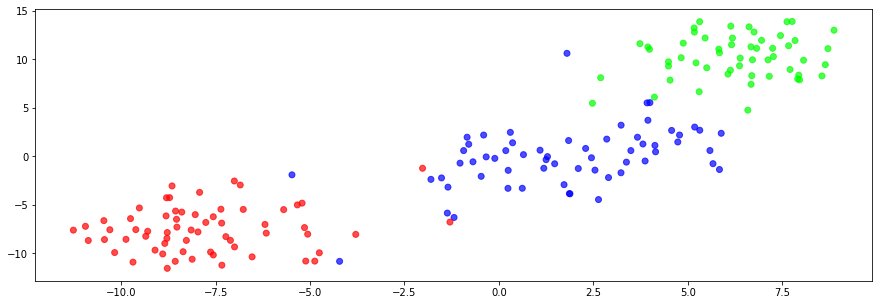

In [44]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=300, random_state = state)
tsne_results = tsne.fit_transform(df_norm)
df_tsne = pd.DataFrame(tsne_results, columns = [0, 1])

plt.figure(figsize = (15, 5))
plt.scatter(df_tsne[0], df_tsne[1], c = best_clusters, cmap = 'brg', alpha = 0.7)
plt.show()

A few points overlap visually, but there are still 3 identifiable clusters. 

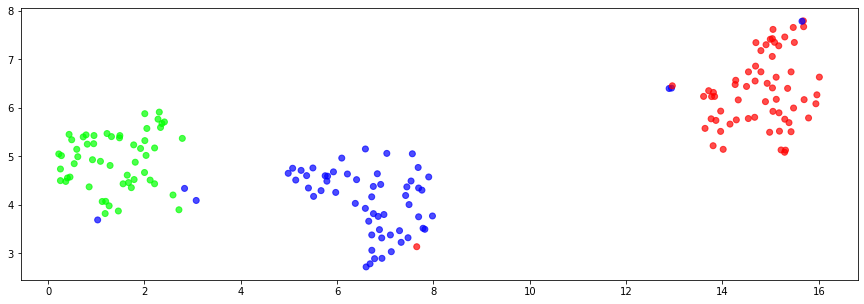

In [45]:
umap_results = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state = state).fit_transform(df_norm)
df_umap = pd.DataFrame(umap_results, columns = [0, 1])

plt.figure(figsize = (15, 5))
plt.scatter(df_umap[0], df_umap[1], c = best_clusters, cmap = 'brg', alpha = 0.7)
plt.show()

There are only 7 points misplaced visually.  This algorithm seems to best reflect the visualization and has the highest silhouette score; a clear winner.

In [46]:
df_clusters_3_dbscan = pd.DataFrame(best_clusters).replace(-1, 2) # Change the identifies for the -1 cluster to 2.
df['3_DBSCAN'] = df_clusters_3_dbscan
df_scores = df_scores.append({'algorithm' : '3_dbscan' , 'silhouette_score' : best_silhouette['silhouette_score'][0]}, ignore_index = True)

In [47]:
df['3_DBSCAN'].unique()

array([0, 2, 1], dtype=int64)

### Comparing the Models

Now that we have found the optimal hyperparameters for each model, we can compare them and decide which is most effective for this application.  We will create a table to compare their scores and discuss the implications of each.

In [48]:
df_scores.sort_values('silhouette_score', ascending = False)

,algorithm,silhouette_score
3,3_dbscan,0.579108
2,3_avg_cos_agg,0.443214
0,3_means,0.300418
1,3_gmm,0.297928


It is obvious that the DBSCAN clustering model creates the most distinct clusters.  When projecting the data onto 2 dimensions, there is slight overlap at the boundaries, but clear clusters are indentifiable.  

In [49]:
k_max = 3
columns = ['feature']
for k in range(0, k_max):
    columns.append('mean_{}'.format(k))
    columns.append('std_{}'.format(k))
df_3_dbscan_stats = pd.DataFrame(columns = columns)
for col in df.columns:
    stats = {'feature' : col}
    for k in range(0, k_max):
        stats.update({'mean_{}'.format(k) : df[col][df['{}_DBSCAN'.format(k_max)] == k].mean()})
        stats.update({'std_{}'.format(k) : df[col][df['{}_DBSCAN'.format(k_max)] == k].std()})
    df_3_dbscan_stats = df_3_dbscan_stats.append(stats, ignore_index = True)

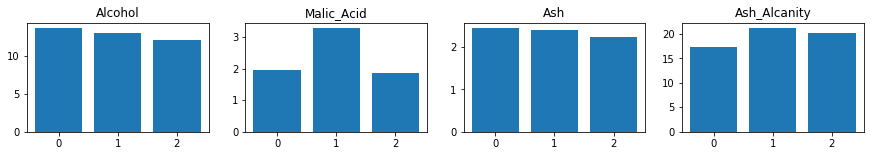

In [50]:
plt.figure(figsize = (15, 2))
subplots = [141, 142, 143, 144]
count = 0
for inx, feature in enumerate(df_3_dbscan_stats['feature'][0:4]):
    plt.subplot(subplots[count])
    heights = []
    for k in range(0, k_max):
        heights.append(df_3_dbscan_stats['mean_{}'.format(k)][df_3_dbscan_stats['feature'] == feature][inx])
    plt.bar(range(0, k_max), heights)
    plt.title(feature)
    count += 1
plt.show()

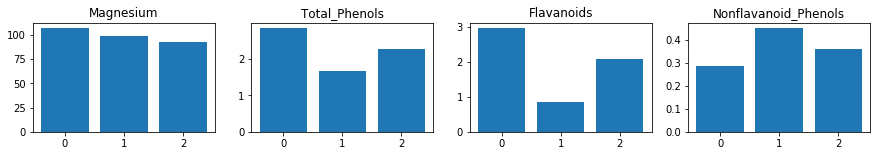

In [51]:
plt.figure(figsize = (15, 2))
subplots = [141, 142, 143, 144]
count = 0
for inx, feature in enumerate(df_3_dbscan_stats['feature'][4:8]):
    plt.subplot(subplots[count])
    heights = []
    for k in range(0, k_max):
        heights.append(df_3_dbscan_stats['mean_{}'.format(k)][df_3_dbscan_stats['feature'] == feature][inx+4])
    plt.bar(range(0, k_max), heights)
    plt.title(feature)
    count += 1
plt.show() 

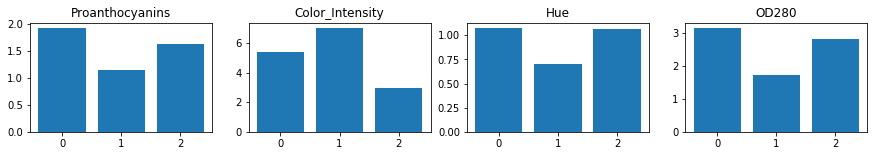

In [52]:
plt.figure(figsize = (15, 2))
subplots = [141, 142, 143, 144]
count = 0
for inx, feature in enumerate(df_3_dbscan_stats['feature'][8:12]):
    plt.subplot(subplots[count])
    heights = []
    for k in range(0, k_max):
        heights.append(df_3_dbscan_stats['mean_{}'.format(k)][df_3_dbscan_stats['feature'] == feature][inx+8])
    plt.bar(range(0, k_max), heights)
    plt.title(feature)
    count += 1
plt.show()

### Conclusion

Cluster 0: This group of wines is high in alcohol, ash, magnesium, flavanoids (and flavanoid phenols), proanthocyanins, and OD280 (protein content).  These wines are low in nonflavanoid phenols, malic acids, ash alcinity, and color intensity.  Those who like wines in this group should seek other wines with many flavanoids and other flavor impacting compounds (ash, proteins, proanthocyanins, ect.).

Cluster 1: The wines in this group are high in malic acid, ash alcanity, nonflavanoid phenols, and color intenisty.  They are low in total phenols (esp flavanoid phenols), flavanoids, proanthocynins, hue, and OD280 proteins.  Those who enjoy this group should look for wines that have high acidity but lower flavor inducing compounds.  

Cluster 2: This is the middling group for most characteristics.  Notably they are lowest in alcohol, color intensity, magnesium, and ash.  This cluster is likely suited to those that do not want as many flavor inducing compounds or high alcohol content.

---

For visualization, it appears the the UMAP dimensionality reduction algorithm created the most distinct clusters after tuning.  However, it was possible to identify 3 clusters in all of the dimensionality reduction techniques used. 

When applying the clustering agorithms, the DBSCAN clustering algorithm produced the most distinct clusters with the highest silhouette score.  Thus it is the model that should be used for grouping datapoints.  

The K-Means, Hierarchical Agglomerative, and Guassian Mixture model identified the clusters in the visualization with little overlap between clusters, but did not have nearly as high silhouette scores. Hierarchical Agglomerative was second best, but still not comparable to DBSCAN.  All models identified 3 clusters as the most distinct number.